# pNeuma understanding the urban traffic monitoring with massive drone data

## Summary: 
When it comes to transportation data, it is emphasized that traffic monitoring and analysis are one of the most important tools. And there are different techniques to collect data from traffic, such as cameras, sensors, GPS, and Unmanned Aerial Systems or called drones.

The pNeuma (New Era of Urban traffic Monitoring with Aerial footage) is an urban dataset to study congestion focused on the use of drones. The goal of this experiment is to record traffic streams in a multi-modal congested environment over an urban setting using UAS that can allow the deep investigation of critical traffic phenomena.

The advantages of the use of drones are that the use of expensive satellites is not necessary, they can be equipped with communication systems to inform commuters in real-time and they have great capabilities in data acquisition. The term "swarm of drones" is used to refer to a coordinated team of drones flying together without colliding to perform a task, for that reason these are perfect to monitor traffic congestion in different parts of a congested city.

The chosen place for this experiment was the central district of the city of Athens, Greece was selected as an urban, multimodal, busy environment that can allow different kinds of transportation phenomena to be examined in which there are 6 types of vehicles that are Car, Taxi, Bus, Medium Vehicle, Heavy Vehicle, Motorcycle. The pNeuma uses a swarm of 10 drones hovering over the city over five days to record traffic streams in a congested area of a 1.3km^2 area with more than 100 km-lanes of road network, around 100 busy intersections (signalized or not), more than 30 bus stops and close to half a million trajectories. 

Drones allow to analyze different traffic parameters, such as speed, flow, density, shockwaves, signal cycle length, queue lengths, queue dissipation time etc. and capacity by generating origin-destination (OD) matrices in the scenario of urban roundabouts and four-legged intersections.

Given the city regulations, the data was captured in the morning peak (8:00-10:30) for each working day of a week. It was important to consider that drones are not able to record the traffic stream for 2.5 hours continuously, so the alternative was to fly the swarm in sequential sessions with 'blind' gaps between, so it was expected that 10 minutes of each 30 minutes of no data would cause no significant issues. 

On the official page of pNeuma we can find the different types of datasets that were captured by each drone in its respective area. The .csv is organized such that each row represents the data of a single vehicle, the first 10 columns in the 1st row include the columns’ names, the first 4 columns include information about the trajectory like the unique trackID, the type of vehicle, the distance traveled and the average speed of the vehicle, the last 6 columns are then repeated every 6 columns based on the time frequency. They can be downloaded depending on a selected date, and the time the capture was made. 


## Data Dictionary:

| Data       | Data Type | Description |Atributes/Measures|   |
|------------|------|-------------|---------|---|
| track_id   |Integer|Track Id of the type of vehicle|Specific "Id" to identify the vehicle type|   |
| Type       |String|Type of Vehicle|Car, Taxi, Bus, Medium Vehicle, Heavy Vehicle, Motorcycle.|   |
| traveled_d |Float|Distance Traveled for the Vehicle|Meters|   |
| lat        |Float|Geographic coodinate of one point from north to south in the earth superfice|Degrees °|   |
| lon        |Float|Geographic coordinate of one point from east to west in the earth superfice|Degrees °|   |
| speed      |Float|Velocity of movement of the vehicle| kilometers per hours(Km/hours)|   |
| lon_acc    |Float| Longitudinal Acceleration| m/sec2|   |
| lat_acc    |Float|Lateral Acceleration| m/sec2|   |
| time       |Float|Time took for the vehicle to move that final distance|Seconds (S)|   |

Note: To work with this you need to use geopandas and movinpandas, if you are working on windows I do recommend to use conda because the installation is easier, do it manually on windows is usually complicated. <br>
If you are on Linux then you can do it manually, you will still have problems but it is easiers to solve.

The pNeuma dataset files are fairly large and do not posses the same number of columns. Direct import into a dataframe is not possible. So, we process line by line, and we  build a dict with the path object as a collection of points. Finally, create a geopandas dataframe from the list of dicts.

A possible problem is that the whole dataset may not fit into ram, then we need to find a way to store information directy in disk.

In [2]:
# Importing the whole libraries that we will use to make the work
import geopandas as gpd
from datetime import datetime, timedelta
import re
import movingpandas as mpd
import numpy as np
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import CRS
import dask.bag as db
import dask.dataframe as dd
from dask.delayed import delayed
import dask_geopandas
import seaborn as sns

## Preproccesing

In [3]:
def get_date_cols(fname):
    pat = re.compile(r'^([0-9]{8})_d([0-9]{1}|[0-9]{2})_([0-9]{2})([0-9]{2})_([0-9]{2})([0-9]{2})\.csv')
    ymd, drone, start_hour, start_min, end_hour, end_min = [int(x) for x in pat.findall(fname)[0]]
    return ymd, start_hour, start_min, drone

In [4]:
def line_to_df(line, date_cols):
    """ Line is a string delimited by ; with trailing newline.
    Create a small df with each line and return it. """
    
    line = line.replace(" ","").split(';')[:-1]
    track_id, type_, traveled_d, avg_speed = line[:4]
    lon = np.array(line[5::6], dtype=float)
    lat = np.array(line[4::6], dtype=float)
    speed = np.array(line[6::6], dtype=float)
    lon_acc = np.array(line[7::6], dtype=float)
    lat_acc = np.array(line[8::6], dtype=float)
    
    # Date information
    n = len(lon)
    ymd, hour, mins, drone = date_cols
    # if the year is different
    # ID = np.full(n, int(str(ymd) + str(drone) + track_id + str(hour) + str(mins)), dtype=np.int64)
    # if the year is the same
    ID = np.full(n, int(str(ymd)[4:] + str(hour) + str(mins) + str(drone) + track_id), dtype=np.int32)
    # It seems time in secs from the start of the experiment chunk
    # Since precision given in sec with two decimals,
    # Rewrite in miliseconds since 8 (integer, avoid precision issues)
    secs = np.array((np.array(line[9::6], dtype=float) + (hour - 8)*3600)*1000, dtype=int)
    # oints = gpd.points_from_xy(lon, lat, crs='EPSG:4326')
    df = pd.DataFrame({'ID': ID, 'type': type_, 'lon': lon, 'lat': lat, 'secs': secs, 'speed':speed, 'long_acc':lon_acc, 'lat_acc':lat_acc})
    
    return df

In [5]:
fname = '20181024_d1_0830_0900.csv'
date_cols = get_date_cols(fname)

In [6]:
f = open(fname)
f.readline();
dfs = [delayed(line_to_df)(l, date_cols) for l in f]
df = dd.from_delayed(dfs)
f.close()

In [7]:
# Write dask df to parquet
df.to_parquet(fname.split('.')[0] + '-points.parquet')

In [8]:
df = dd.read_parquet(fname.split('.')[0] + '-points.parquet')

In [9]:
df = dask_geopandas.from_dask_dataframe(df)
df = df.set_geometry(
    dask_geopandas.points_from_xy(df, 'lon', 'lat')
)

In [10]:
df.head()

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
0,102483011,Car,23.737688,37.977391,0,4.9178,0.0518,-0.0299,POINT (23.73769 37.97739)
1,102483011,Car,23.737688,37.977391,40,4.9207,-0.0124,-0.0354,POINT (23.73769 37.97739)
2,102483011,Car,23.737688,37.977391,80,4.9160,-0.0519,-0.0413,POINT (23.73769 37.97739)
3,102483011,Car,23.737688,37.977390,120,4.9057,-0.0914,-0.0478,POINT (23.73769 37.97739)
4,102483011,Car,23.737689,37.977390,160,4.8871,-0.1679,-0.0550,POINT (23.73769 37.97739)


## Victor y Luis's Part

### Take random samples

In [11]:
df_s=df.sample(frac=0.05, replace=None, random_state=10)

In [12]:
df_s = df_s.compute()

In [13]:
type(df_s)

geopandas.geodataframe.GeoDataFrame

In [14]:
df_s.head()

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
367,102483011,Car,23.737770,37.977276,14680,23.2094,2.9924,0.5883,POINT (23.73777 37.97728)
71,102483011,Car,23.737699,37.977375,2840,1.7049,-0.1182,-0.0557,POINT (23.73770 37.97738)
290,102483011,Car,23.737724,37.977342,11600,1.2040,0.1415,-0.0067,POINT (23.73772 37.97734)
189,102483011,Car,23.737717,37.977352,7560,1.4829,-0.6960,0.0299,POINT (23.73772 37.97735)
185,102483011,Car,23.737716,37.977352,7400,1.8952,-0.7258,0.0367,POINT (23.73772 37.97735)


### Obtener histogramas condicionados en tipo de vehiculo y hora

In [15]:
import matplotlib.pyplot as plt
import matplotlib

In [16]:
# Drop ID duplicates to find the total amount of vehicles
cars = df_s.drop_duplicates('ID')

In [17]:
df_s.shape

(72425, 9)

In [18]:
cars.shape

(922, 9)

In [19]:
cars.head()

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
367,102483011,Car,23.737770,37.977276,14680,23.2094,2.9924,0.5883,POINT (23.73777 37.97728)
137,102483012,Motorcycle,23.737663,37.977479,5480,16.2138,-0.6460,-0.1384,POINT (23.73766 37.97748)
123,102483013,Motorcycle,23.737486,37.977726,4920,26.4321,-1.2616,0.1476,POINT (23.73749 37.97773)
206,102483014,Motorcycle,23.737255,37.977920,8240,38.5092,1.3700,0.1919,POINT (23.73726 37.97792)
346,102483015,Motorcycle,23.737574,37.977527,13840,34.3382,-1.0395,0.5758,POINT (23.73757 37.97753)


In [20]:
cars.tail(5)

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
165,1658367326,Car,23.735443,37.980199,816200,30.4291,0.5338,0.0988,POINT (23.73544 37.98020)
129,1658367327,Motorcycle,23.735556,37.979298,816360,13.7747,0.6607,0.0234,POINT (23.73556 37.97930)
110,1658367328,Car,23.735810,37.978561,816000,25.2085,0.2345,-0.2173,POINT (23.73581 37.97856)
98,1658367329,Motorcycle,23.736527,37.979833,817120,28.2510,-2.2476,0.0908,POINT (23.73653 37.97983)
115,1658367330,Car,23.735830,37.978576,818000,21.8395,-0.4724,-0.1353,POINT (23.73583 37.97858)


##### Histograma para contar el numero de cada vehiculo en la muestra

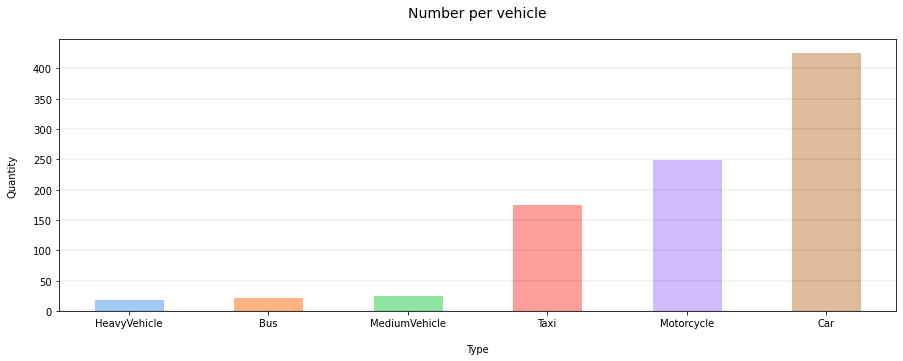

In [21]:
# The number of vehicles per category
fig, ax = plt.subplots(figsize=(15, 5))
ax = cars["type"].value_counts().sort_values().plot(kind='bar', color=sns.color_palette('pastel',10), edgecolor='white') 
plt.title("Number per vehicle\n", size=14)
plt.xlabel("\nType")
plt.xticks(rotation=0)
plt.ylabel("Quantity\n");

ax.grid(axis='y', linestyle='-', linewidth=.1, color='black')
plt.show()

##### Histograma de la velocidad en la muestra

In [22]:
df_s.head()

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
367,102483011,Car,23.737770,37.977276,14680,23.2094,2.9924,0.5883,POINT (23.73777 37.97728)
71,102483011,Car,23.737699,37.977375,2840,1.7049,-0.1182,-0.0557,POINT (23.73770 37.97738)
290,102483011,Car,23.737724,37.977342,11600,1.2040,0.1415,-0.0067,POINT (23.73772 37.97734)
189,102483011,Car,23.737717,37.977352,7560,1.4829,-0.6960,0.0299,POINT (23.73772 37.97735)
185,102483011,Car,23.737716,37.977352,7400,1.8952,-0.7258,0.0367,POINT (23.73772 37.97735)


In [23]:
df_s["secs"].max()

818800

In [24]:
df_s["secs"].min()

0

In [25]:
# Separete into groups
g1 = df_s.loc[(df_s['secs'] >= 0) & (df_s['secs']<= 80000)]
g2 = df_s.loc[(df_s['secs'] > 80000) & (df_s['secs']<= 160000)]
g3 = df_s.loc[(df_s['secs'] > 160000) & (df_s['secs']<= 240000)]
g4 = df_s.loc[(df_s['secs'] > 240000) & (df_s['secs']<= 320000)]
g5 = df_s.loc[(df_s['secs'] > 320000) & (df_s['secs']<= 400000)]
g6 = df_s.loc[(df_s['secs'] > 400000) & (df_s['secs']<= 480000)]
g7 = df_s.loc[(df_s['secs'] > 480000) & (df_s['secs']<= 560000)]
g8 = df_s.loc[(df_s['secs'] > 560000) & (df_s['secs']<= 640000)]
g9 = df_s.loc[(df_s['secs'] > 640000) & (df_s['secs']<= 720000)]
g10 = df_s.loc[(df_s['secs'] > 720000) & (df_s['secs']<= 818800)]

In [26]:
# Get averagespeed
g1_speed = g1["speed"].mean()
g2_speed = g2["speed"].mean()
g3_speed = g3["speed"].mean()
g4_speed = g4["speed"].mean()
g5_speed = g5["speed"].mean()
g6_speed = g6["speed"].mean()
g7_speed = g7["speed"].mean()
g8_speed = g8["speed"].mean()
g9_speed = g9["speed"].mean()
g10_speed = g10["speed"].mean()

In [27]:
speed_dic = {'Range': ["0-80000", "80001-160000", "160001-240000", "240001-320000", "320001-400000", "400001-480000", "480001-560000", "560001-640000", "640001-720000", "720001-818800"],
     'Average Speed': [g1["speed"].mean(), g2["speed"].mean(), g3["speed"].mean(), g4["speed"].mean(), g5["speed"].mean(), g6["speed"].mean(), g7["speed"].mean(), g8["speed"].mean(), g9["speed"].mean(), g10["speed"].mean()]}

In [28]:
speed_df = pd.DataFrame(data=speed_dic).set_index('Range')

In [29]:
speed_df

,Average Speed
Range,
0-80000,18.357226
80001-160000,17.158119
160001-240000,19.394876
240001-320000,18.587303
320001-400000,15.976506
400001-480000,15.554472
480001-560000,14.896587
560001-640000,16.268454
640001-720000,15.576401


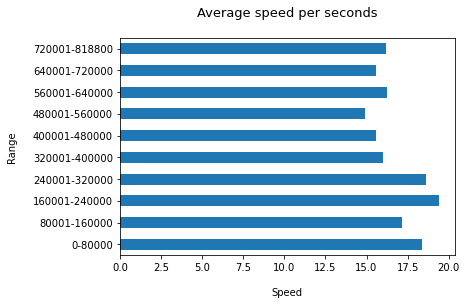

In [30]:
speed_df["Average Speed"].plot(kind = 'barh').figsize=(10, 5)
plt.title("Average speed per seconds\n", size=13)
plt.xlabel("\nSpeed")
plt.xticks(rotation=0)
plt.ylabel("Range\n");
plt.show()

## Plotear las diferentes distribuciones para cada tipo de vehiculo

In [31]:
from scipy import stats as st
import matplotlib.pyplot as plt

In [32]:
df = df.compute()

## Car

Take the rows type "Car" and the one which are greater than zero

In [32]:
type_car = df[((df['type'] == 'Car') & (df['speed'] > 0))]

Plot histogram of the speed in cars

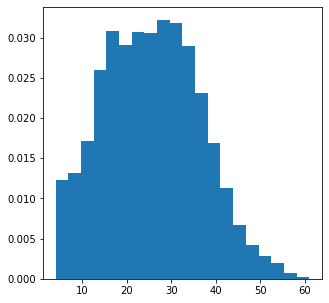

In [33]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_car['speed'], density = True, range=(4,61), bins = 20)
plt.show()

### - Normal

In [34]:
mu, sigma = st.norm.fit(type_car['speed'])

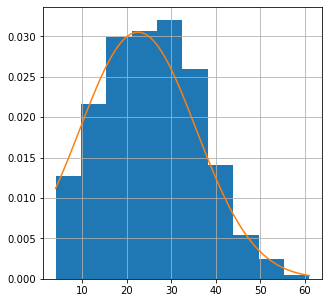

In [35]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_car['speed'], density = True, range=(4,61), bins = 10)
grid = np.linspace(4, 61, 100)
ax.plot(grid, st.norm.pdf(grid, mu, sigma))
ax.grid()
plt.show()

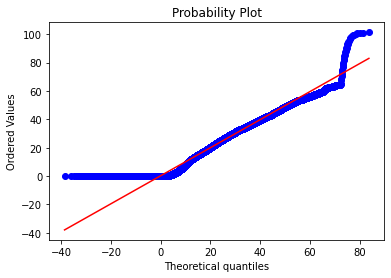

In [36]:
fig, ax = plt.subplots()
res = st.probplot(type_car['speed'], sparams=(mu, sigma), dist=st.norm, plot=ax)

In [37]:
norm_p = st.norm.sf(80,mu,sigma)
norm_p

5.453837354389173e-06

In [41]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(22.190045696528664, 12.988018264982832)


Optimization terminated successfully.
         Current function value: 3.982966
         Iterations: 30
         Function evaluations: 60
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -3983.0
Model:                           Norm   AIC:                             7972.
Method:            Maximum Likelihood   BIC:                             7987.
Date:                Sat, 10 Apr 2021                                         
Time:                        23:37:52                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### - Log Normal

In [42]:
shape, loc, scale = st.lognorm.fit(type_car['speed'])

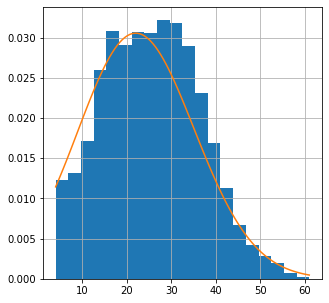

In [43]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_car['speed'], density = True, range=(4,61), bins = 20)
grid = np.linspace(4, 61, 100)
ax.plot(grid, st.lognorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

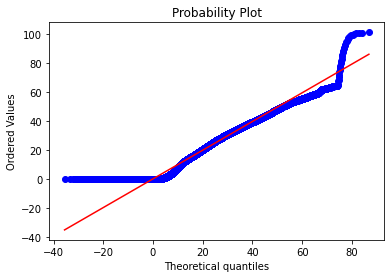

In [44]:
fig, ax = plt.subplots()
res = st.probplot(type_car['speed'], sparams=(shape, loc, scale), dist=st.lognorm, plot=ax)

In [45]:
# Log norm
shape, loc, scale = st.lognorm.fit(type_car['speed'])
lognorm_p = st.lognorm.sf(80,shape)
lognorm_p

0.0

In [46]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.lognorm.rvs(shape, loc, scale, size=1000)
params = st.lognorm.fit(data)

print(params)
print('\n')


class LogNorm(GenericLikelihoodModel):

    nparams = 3

    def loglike(self, params):
        return st.lognorm.logpdf(self.endog, *params).sum()


res = LogNorm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(0.14944339015448949, -65.44329287944083, 87.65418565189267)


Optimization terminated successfully.
         Current function value: 4.004917
         Iterations: 261
         Function evaluations: 445
                               LogNorm Results                                
Dep. Variable:                      y   Log-Likelihood:                -4004.9
Model:                        LogNorm   AIC:                             8018.
Method:            Maximum Likelihood   BIC:                             8037.
Date:                Sat, 10 Apr 2021                                         
Time:                        23:59:26                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

### - Exponential

In [42]:
shape, loc, scale = st.exponnorm.fit(type_car['speed'])

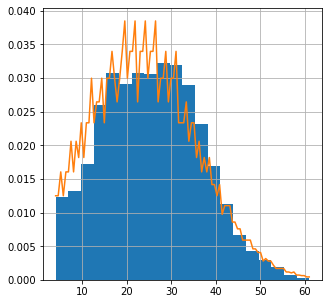

In [43]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_car['speed'], density = True, range=(4,61), bins = 20)
grid = np.linspace(4, 61, 100)
ax.plot(grid, st.exponnorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

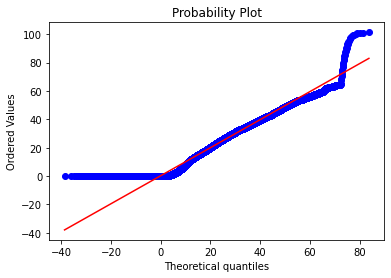

In [44]:
fig, ax = plt.subplots()
res = st.probplot(type_car['speed'], sparams=(shape, loc, scale), dist=st.exponnorm, plot=ax)

In [45]:
# Expon norm
shape, loc, scale = st.exponnorm.fit(type_car['speed'])
expon_norm = st.exponnorm.sf(80,shape)
expon_norm

0.0

### - Power Law

In [46]:
shape, loc, scale = st.powerlaw.fit(type_car['speed'])

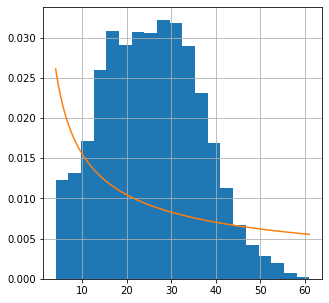

In [47]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_car['speed'], density = True, range=(4,61), bins = 20)
grid = np.linspace(4, 61, 100)
ax.plot(grid, st.powerlaw.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

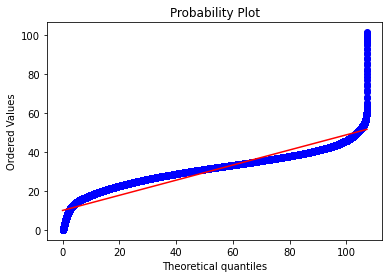

In [48]:
fig, ax = plt.subplots()
res = st.probplot(type_car['speed'], sparams=(shape, loc, scale), dist=st.powerlaw, plot=ax)

In [49]:
# Power law
shape, loc, scale = st.powerlaw.fit(type_car['speed'])
powelaw = st.powerlaw.sf(80,shape)
powelaw

0.0

## Motorcycle

In [47]:
type_Motorcycle = df[((df['type'] == 'Motorcycle') & (df['speed'] > 1))]

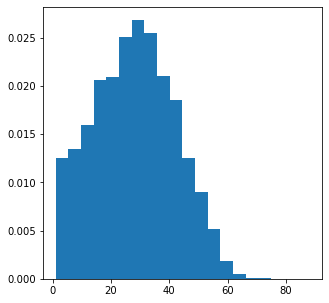

In [48]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Motorcycle['speed'], density = True, range=(1,88), bins = 20)
plt.show()

### - Normal Distribution

In [49]:
mu, sigma = st.norm.fit(type_Motorcycle['speed'])

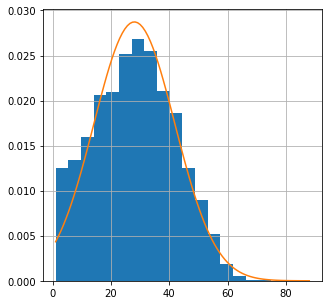

In [50]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Motorcycle['speed'], density = True, range=(1,88), bins = 20)
grid = np.linspace(1, 88, 100)
ax.plot(grid, st.norm.pdf(grid, mu, sigma))
ax.grid()
plt.show()

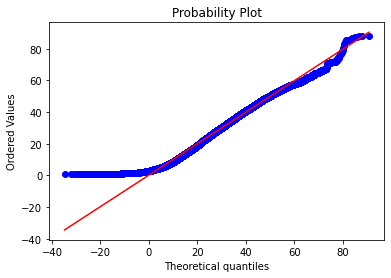

In [51]:
fig, ax = plt.subplots()
res = st.probplot(type_Motorcycle['speed'], sparams=(mu, sigma), dist=st.norm, plot=ax)

In [52]:
norm_p = st.norm.sf(80,mu,sigma)
norm_p

9.053198886409833e-05

In [53]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(27.91430402249301, 13.614882905440153)


Optimization terminated successfully.
         Current function value: 4.030102
         Iterations: 29
         Function evaluations: 59
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -4030.1
Model:                           Norm   AIC:                             8066.
Method:            Maximum Likelihood   BIC:                             8081.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:06:13                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

### - Log Normal Distribution

In [54]:
shape, loc, scale = st.lognorm.fit(type_Motorcycle['speed'])

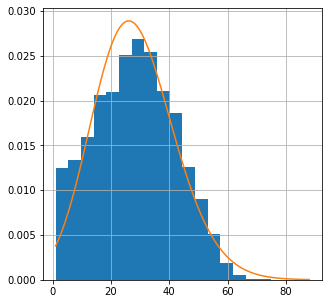

In [55]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Motorcycle['speed'], density = True, range=(1,88), bins = 20)
grid = np.linspace(1, 88, 100)
ax.plot(grid, st.lognorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

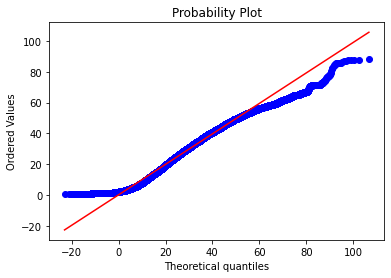

In [56]:
fig, ax = plt.subplots()
res = st.probplot(type_Motorcycle['speed'], sparams=(shape, loc, scale), dist=st.lognorm, plot=ax)

In [57]:
lognorm_p = st.lognorm.sf(80,shape)
lognorm_p

0.0

In [58]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.lognorm.rvs(shape, loc, scale, size=1000)
params = st.lognorm.fit(data)

print(params)
print('\n')


class LogNorm(GenericLikelihoodModel):

    nparams = 3

    def loglike(self, params):
        return st.lognorm.logpdf(self.endog, *params).sum()


res = LogNorm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(0.14555336731556673, -68.69689085151148, 95.71962997878163)


Optimization terminated successfully.
         Current function value: 4.053149
         Iterations: 78
         Function evaluations: 138
                               LogNorm Results                                
Dep. Variable:                      y   Log-Likelihood:                -4053.1
Model:                        LogNorm   AIC:                             8114.
Method:            Maximum Likelihood   BIC:                             8134.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:06:47                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------

### - Exponential Distribution

In [60]:
shape, loc, scale = st.exponnorm.fit(type_Motorcycle['speed'])

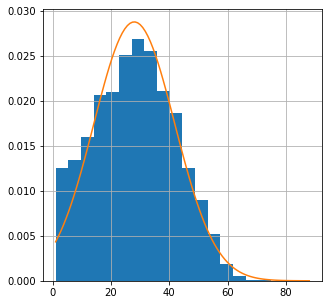

In [61]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Motorcycle['speed'], density = True, range=(1,88), bins = 20)
grid = np.linspace(1,88, 100)
ax.plot(grid, st.exponnorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

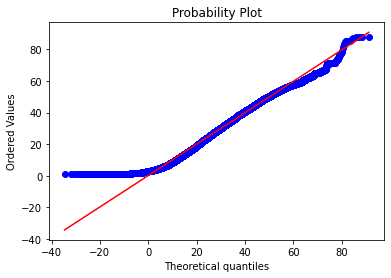

In [62]:
fig, ax = plt.subplots()
res = st.probplot(type_Motorcycle['speed'], sparams=(shape, loc, scale), dist=st.exponnorm, plot=ax)

In [63]:
expon_norm = st.exponnorm.sf(80,shape)
expon_norm

1.0610448021891807e-230

### - Power Law Distribution

In [64]:
shape, loc, scale = st.powerlaw.fit(type_Motorcycle['speed'])

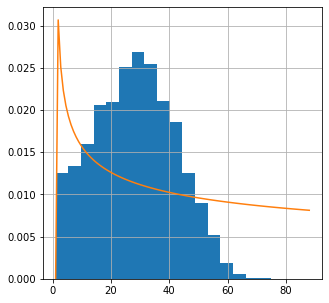

In [65]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Motorcycle['speed'], density = True, range=(1,88), bins = 20)
grid = np.linspace(1,88, 100)
ax.plot(grid, st.powerlaw.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

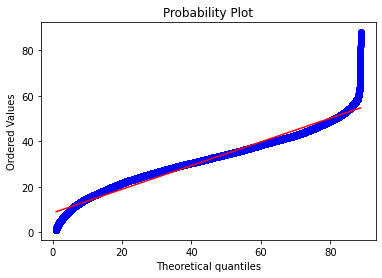

In [66]:
fig, ax = plt.subplots()
res = st.probplot(type_Motorcycle['speed'], sparams=(shape, loc, scale), dist=st.powerlaw, plot=ax)

In [67]:
powelaw = st.powerlaw.sf(80,shape)
powelaw

0.0

## Medium Vehicle

In [59]:
type_MidVehicle = df[((df['type'] == 'MediumVehicle') & (df['speed'] > 1))]

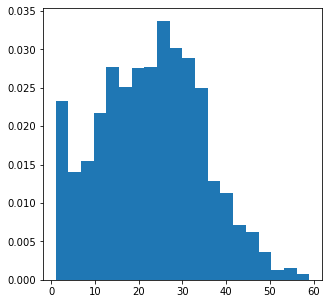

In [60]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_MidVehicle['speed'], density = True, range=(1,59), bins = 20)
plt.show()

### - Normal Distribution

In [61]:
mu, sigma = st.norm.fit(type_MidVehicle['speed'])

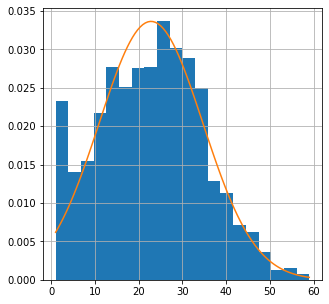

In [62]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_MidVehicle['speed'], density = True, range=(1,59), bins = 20)
grid = np.linspace(1,59, 100)
ax.plot(grid, st.norm.pdf(grid, mu, sigma))
ax.grid()
plt.show()

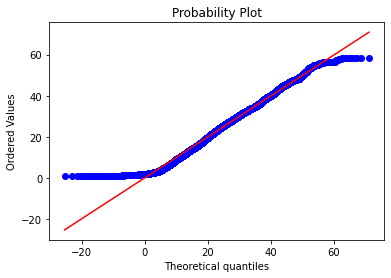

In [63]:
fig, ax = plt.subplots()
res = st.probplot(type_MidVehicle['speed'], sparams=(mu, sigma), dist=st.norm, plot=ax)

In [64]:
norm_p = st.norm.sf(80,mu,sigma)
norm_p

7.034339079669217e-07

In [65]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(22.756133120020174, 11.705032148607888)


Optimization terminated successfully.
         Current function value: 3.878957
         Iterations: 29
         Function evaluations: 58
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -3879.0
Model:                           Norm   AIC:                             7764.
Method:            Maximum Likelihood   BIC:                             7779.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:07:14                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### - Log Normal Distribution

In [66]:
shape, loc, scale = st.lognorm.fit(type_MidVehicle['speed'])

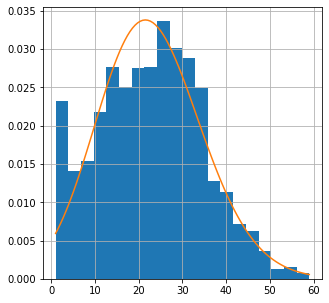

In [67]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_MidVehicle['speed'], density = True, range=(1,59), bins = 20)
grid = np.linspace(1,59, 100)
ax.plot(grid, st.lognorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

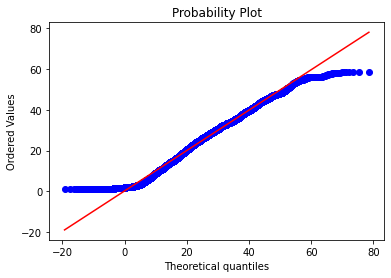

In [68]:
fig, ax = plt.subplots()
res = st.probplot(type_MidVehicle['speed'], sparams=(shape, loc, scale), dist=st.lognorm, plot=ax)

In [69]:
lognorm_p = st.lognorm.sf(80,shape)
lognorm_p

0.0

In [70]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.lognorm.rvs(shape, loc, scale, size=1000)
params = st.lognorm.fit(data)

print(params)
print('\n')


class LogNorm(GenericLikelihoodModel):

    nparams = 3

    def loglike(self, params):
        return st.lognorm.logpdf(self.endog, *params).sum()


res = LogNorm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(0.024483800047040337, -463.1043627293419, 485.31704532651406)


Optimization terminated successfully.
         Current function value: 3.894032
         Iterations: 92
         Function evaluations: 181
                               LogNorm Results                                
Dep. Variable:                      y   Log-Likelihood:                -3894.0
Model:                        LogNorm   AIC:                             7796.
Method:            Maximum Likelihood   BIC:                             7816.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:07:21                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------

### - Exponential Distribution

In [78]:
shape, loc, scale = st.exponnorm.fit(type_MidVehicle['speed'])

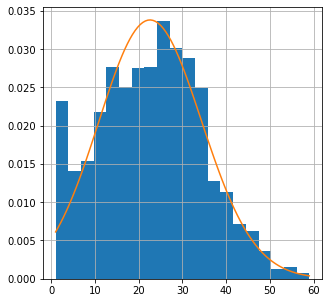

In [79]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_MidVehicle['speed'], density = True, range=(1,59), bins = 20)
grid = np.linspace(1,59, 100)
ax.plot(grid, st.exponnorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

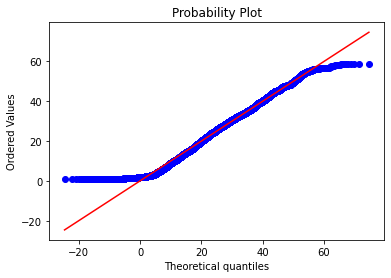

In [80]:
fig, ax = plt.subplots()
res = st.probplot(type_MidVehicle['speed'], sparams=(shape, loc, scale), dist=st.exponnorm, plot=ax)

In [81]:
expon_norm = st.exponnorm.sf(80,shape)
expon_norm

3.001474489421262e-113

### - Power Law Distribution

In [82]:
shape, loc, scale = st.powerlaw.fit(type_MidVehicle['speed'])

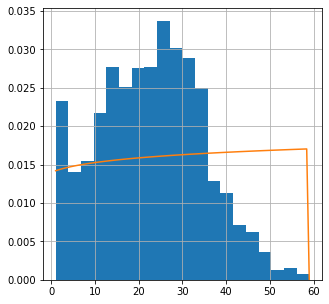

In [83]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_MidVehicle['speed'], density = True, range=(1,59), bins = 20)
grid = np.linspace(1,59, 100)
ax.plot(grid, st.powerlaw.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

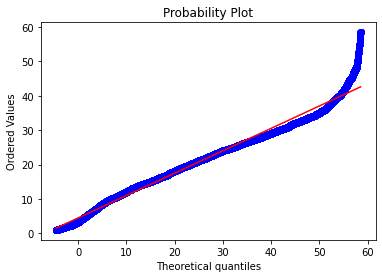

In [84]:
fig, ax = plt.subplots()
res = st.probplot(type_MidVehicle['speed'], sparams=(shape, loc, scale), dist=st.powerlaw, plot=ax)

In [85]:
powelaw = st.powerlaw.sf(80,shape)
powelaw

0.0

## Bus

In [33]:
type_Bus = df[((df['type'] == 'Bus') & (df['speed'] > 1))]

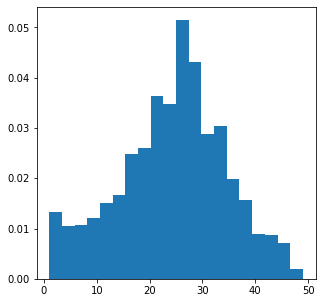

In [34]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Bus['speed'], density = True, range=(1,49), bins = 20)
plt.show()

### - Normal Distribution

In [73]:
mu, sigma = st.norm.fit(type_Bus['speed'])

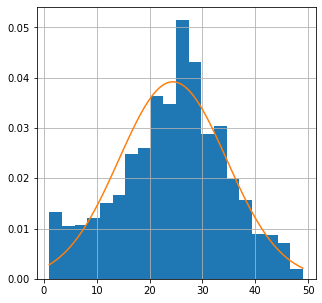

In [74]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Bus['speed'], density = True, range=(1,49), bins = 20)
grid = np.linspace(1, 49, 100)
ax.plot(grid, st.norm.pdf(grid, mu, sigma))
ax.grid()
plt.show()

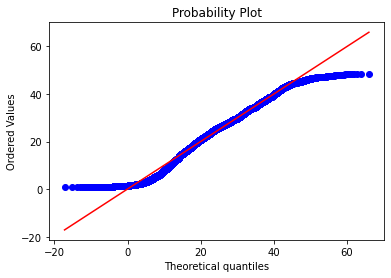

In [75]:
fig, ax = plt.subplots()
res = st.probplot(type_Bus['speed'], sparams=(mu, sigma), dist=st.norm, plot=ax)

In [76]:
norm_p = st.norm.sf(80,mu,sigma)
norm_p

2.3465078910482598e-08

In [77]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(23.706738102862662, 10.240122352622533)


Optimization terminated successfully.
         Current function value: 3.745252
         Iterations: 28
         Function evaluations: 57
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -3745.3
Model:                           Norm   AIC:                             7497.
Method:            Maximum Likelihood   BIC:                             7511.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:07:47                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### - Log Normal Distribution

In [78]:
shape, loc, scale = st.lognorm.fit(type_Bus['speed'])

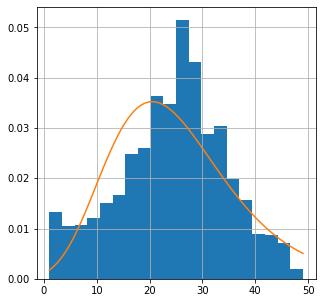

In [79]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Bus['speed'], density = True, range=(1,49), bins = 20)
grid = np.linspace(1, 49, 100)
ax.plot(grid, st.lognorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

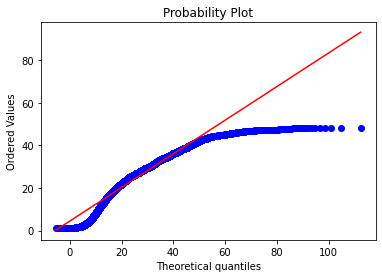

In [80]:
fig, ax = plt.subplots()
res = st.probplot(type_Bus['speed'], sparams=(shape, loc, scale), dist=st.lognorm, plot=ax)

In [81]:
lognorm_p = st.lognorm.sf(80,shape)
lognorm_p

1.1603225305756471e-57

In [82]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.lognorm.rvs(shape, loc, scale, size=1000)
params = st.lognorm.fit(data)

print(params)
print('\n')


class LogNorm(GenericLikelihoodModel):

    nparams = 3

    def loglike(self, params):
        return st.lognorm.logpdf(self.endog, *params).sum()


res = LogNorm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(0.2626249849096609, -21.316828847034927, 44.91764667970999)


Optimization terminated successfully.
         Current function value: 3.886741
         Iterations: 70
         Function evaluations: 120
                               LogNorm Results                                
Dep. Variable:                      y   Log-Likelihood:                -3886.7
Model:                        LogNorm   AIC:                             7781.
Method:            Maximum Likelihood   BIC:                             7801.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:07:54                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------

### - Exponential Distribution

In [96]:
shape, loc, scale = st.exponnorm.fit(type_Bus['speed'])

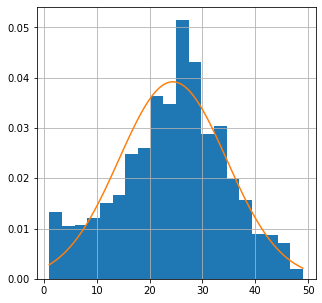

In [97]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Bus['speed'], density = True, range=(1,49), bins = 20)
grid = np.linspace(1,49, 100)
ax.plot(grid, st.exponnorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

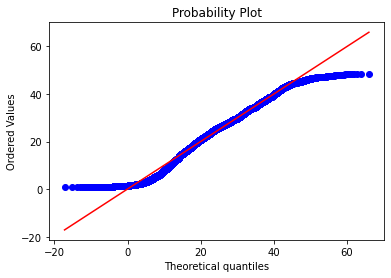

In [98]:
fig, ax = plt.subplots()
res = st.probplot(type_Bus['speed'], sparams=(shape, loc, scale), dist=st.exponnorm, plot=ax)

In [99]:
expon_norm = st.exponnorm.sf(80,shape)
expon_norm

0.0

### - Power Law Distribution

In [100]:
shape, loc, scale = st.powerlaw.fit(type_Bus['speed'])

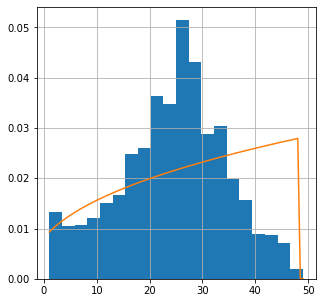

In [101]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Bus['speed'], density = True, range=(1,49), bins = 20)
grid = np.linspace(1,49, 100)
ax.plot(grid, st.powerlaw.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

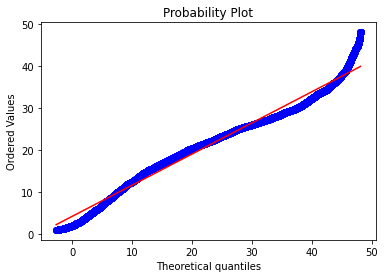

In [102]:
fig, ax = plt.subplots()
res = st.probplot(type_Bus['speed'], sparams=(shape, loc, scale), dist=st.powerlaw, plot=ax)

In [103]:
powelaw = st.powerlaw.sf(80,shape)
powelaw

0.0

### - Laplace Distribution

In [36]:
mu, sigma = st.laplace.fit(type_Bus['speed'])

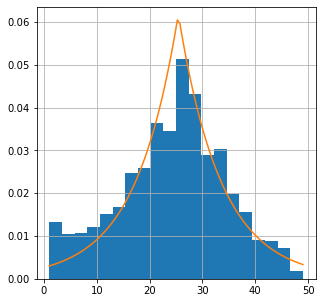

In [37]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Bus['speed'], density = True, range=(1,49), bins = 20)
grid = np.linspace(1, 49, 100)
ax.plot(grid, st.laplace.pdf(grid, mu, sigma))
ax.grid()
plt.show()

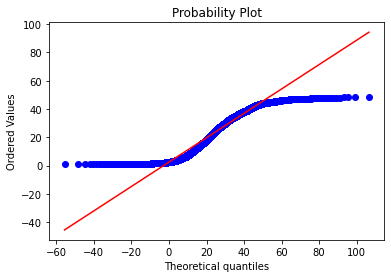

In [39]:
fig, ax = plt.subplots()
res = st.probplot(type_Bus['speed'], sparams=(mu, sigma), dist=st.laplace, plot=ax)

In [40]:
norm_p = st.laplace.sf(80,mu,sigma)
norm_p

0.0005803956619609973

In [41]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(24.937367272058616, 7.823736154583297)


Optimization terminated successfully.
         Current function value: 3.476101
         Iterations: 27
         Function evaluations: 55
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -3476.1
Model:                           Norm   AIC:                             6958.
Method:            Maximum Likelihood   BIC:                             6973.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:33:13                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

## Taxi

In [83]:
type_Taxi = df[((df['type'] == 'Taxi') & (df['speed'] > 1))]

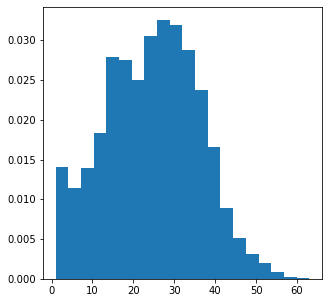

In [84]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Taxi['speed'], density = True, range=(1,63), bins = 20)
plt.show()

### - Normal Distribution

In [85]:
mu, sigma = st.norm.fit(type_Taxi['speed'])

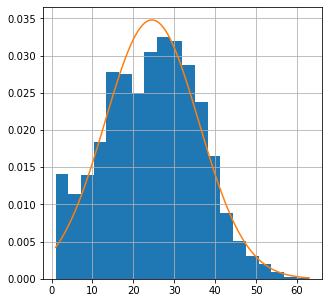

In [86]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Taxi['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1, 63, 100)
ax.plot(grid, st.norm.pdf(grid, mu, sigma))
ax.grid()
plt.show()

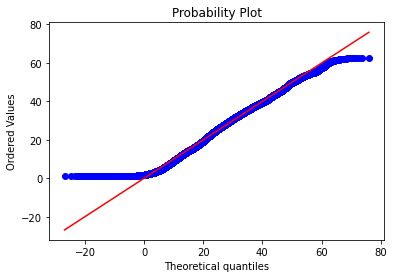

In [87]:
fig, ax = plt.subplots()
res = st.probplot(type_Taxi['speed'], sparams=(mu, sigma), dist=st.norm, plot=ax)

In [88]:
norm_p = st.norm.sf(80,mu,sigma)
norm_p

6.562401175079707e-07

In [89]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(23.91843692850117, 11.991601448129927)


Optimization terminated successfully.
         Current function value: 3.903145
         Iterations: 28
         Function evaluations: 57
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -3903.1
Model:                           Norm   AIC:                             7812.
Method:            Maximum Likelihood   BIC:                             7827.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:08:07                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

### - Log Normal Distribution

In [90]:
shape, loc, scale = st.lognorm.fit(type_Taxi['speed'])

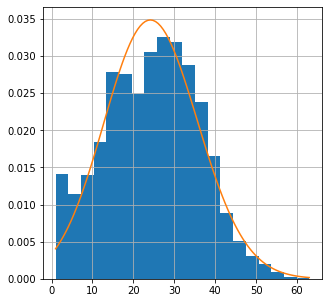

In [91]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Taxi['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1, 63, 100)
ax.plot(grid, st.lognorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

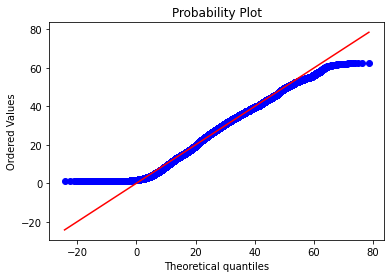

In [92]:
fig, ax = plt.subplots()
res = st.probplot(type_Taxi['speed'], sparams=(shape, loc, scale), dist=st.lognorm, plot=ax)

In [93]:
lognorm_p = st.lognorm.sf(80,shape)
lognorm_p

0.0

In [94]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.lognorm.rvs(shape, loc, scale, size=1000)
params = st.lognorm.fit(data)

print(params)
print('\n')


class LogNorm(GenericLikelihoodModel):

    nparams = 3

    def loglike(self, params):
        return st.lognorm.logpdf(self.endog, *params).sum()


res = LogNorm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(0.052321490935348464, -197.86988706832756, 222.41127814735796)


Optimization terminated successfully.
         Current function value: 3.873119
         Iterations: 81
         Function evaluations: 145
                               LogNorm Results                                
Dep. Variable:                      y   Log-Likelihood:                -3873.1
Model:                        LogNorm   AIC:                             7754.
Method:            Maximum Likelihood   BIC:                             7774.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:08:36                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

### - Exponential Distribution

In [114]:
shape, loc, scale = st.exponnorm.fit(type_Taxi['speed'])

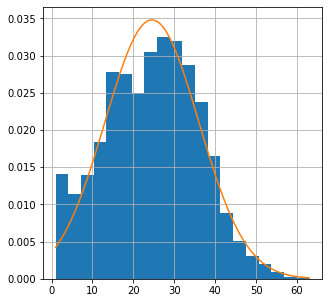

In [115]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Taxi['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1,63, 100)
ax.plot(grid, st.exponnorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

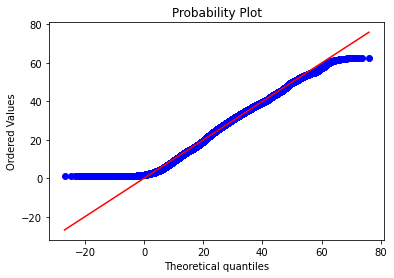

In [116]:
fig, ax = plt.subplots()
res = st.probplot(type_Taxi['speed'], sparams=(shape, loc, scale), dist=st.exponnorm, plot=ax)

In [117]:
expon_norm = st.exponnorm.sf(80,shape)
expon_norm

0.0

### - Power Law Distribution

In [118]:
shape, loc, scale = st.powerlaw.fit(type_Taxi['speed'])

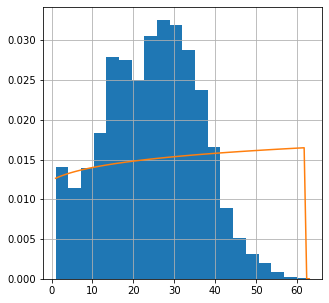

In [119]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_Taxi['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1,63, 100)
ax.plot(grid, st.powerlaw.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

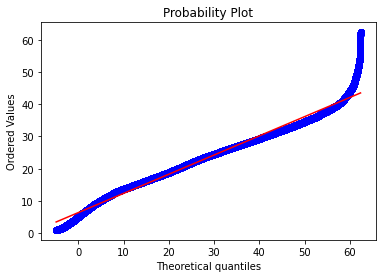

In [120]:
fig, ax = plt.subplots()
res = st.probplot(type_Taxi['speed'], sparams=(shape, loc, scale), dist=st.powerlaw, plot=ax)

In [121]:
powelaw = st.powerlaw.sf(80,shape)
powelaw

0.0

## Heavy Vehicle

In [95]:
type_HeavyVehicle = df[((df['type'] == 'Taxi') & (df['speed'] > 1))]

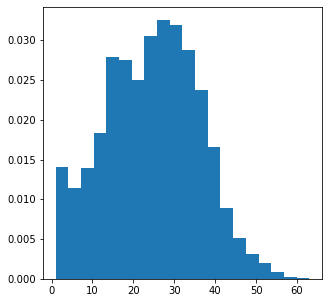

In [96]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_HeavyVehicle['speed'], density = True, range=(1,63), bins = 20)
plt.show()

### - Normal Distribution

In [97]:
mu, sigma = st.norm.fit(type_HeavyVehicle['speed'])

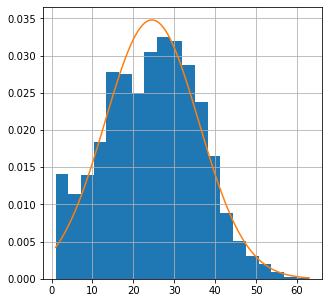

In [98]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_HeavyVehicle['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1, 63, 100)
ax.plot(grid, st.norm.pdf(grid, mu, sigma))
ax.grid()
plt.show()

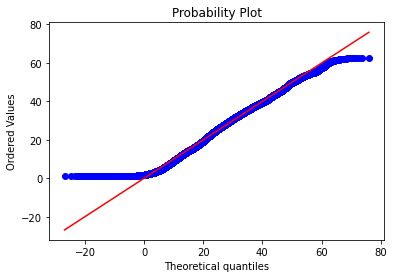

In [99]:
fig, ax = plt.subplots()
res = st.probplot(type_HeavyVehicle['speed'], sparams=(mu, sigma), dist=st.norm, plot=ax)

In [100]:
norm_p = st.norm.sf(80,mu,sigma)
norm_p

6.562401175079707e-07

In [101]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.norm.rvs(mu, sigma, size=1000)
params = st.norm.fit(data)

print(params)
print('\n')


class Norm(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):
        return st.norm.logpdf(self.endog, *params).sum()


res = Norm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(24.72794320251949, 11.500515888750668)


Optimization terminated successfully.
         Current function value: 3.861330
         Iterations: 29
         Function evaluations: 59
                                 Norm Results                                 
Dep. Variable:                      y   Log-Likelihood:                -3861.3
Model:                           Norm   AIC:                             7729.
Method:            Maximum Likelihood   BIC:                             7743.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:08:53                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

### - Log Normal Distribution

In [102]:
shape, loc, scale = st.lognorm.fit(type_HeavyVehicle['speed'])

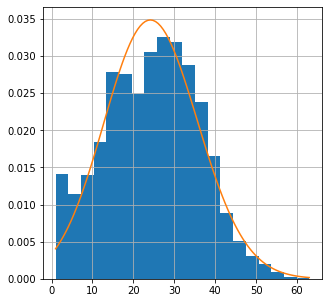

In [103]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_HeavyVehicle['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1, 63, 100)
ax.plot(grid, st.lognorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

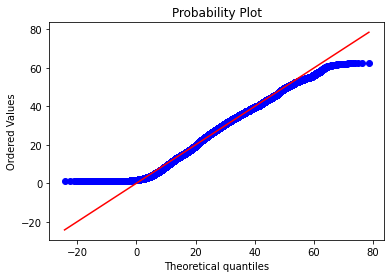

In [104]:
fig, ax = plt.subplots()
res = st.probplot(type_HeavyVehicle['speed'], sparams=(shape, loc, scale), dist=st.lognorm, plot=ax)

In [105]:
lognorm_p = st.lognorm.sf(80,shape)
lognorm_p

0.0

In [106]:
from statsmodels.base.model import GenericLikelihoodModel

data = st.lognorm.rvs(shape, loc, scale, size=1000)
params = st.lognorm.fit(data)

print(params)
print('\n')


class LogNorm(GenericLikelihoodModel):

    nparams = 3

    def loglike(self, params):
        return st.lognorm.logpdf(self.endog, *params).sum()


res = LogNorm(data).fit(start_params=params)
res.df_model = len(params)
res.df_resid = len(data) - len(params)
print(res.summary())

(3.0071287293559275, -11.736186475785743, 2.862857275118933)


                               LogNorm Results                                
Dep. Variable:                      y   Log-Likelihood:                -3818.9
Model:                        LogNorm   AIC:                             7646.
Method:            Maximum Likelihood   BIC:                             7666.
Date:                Sun, 11 Apr 2021                                         
Time:                        00:09:20                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
par0           0.0046      0.005      1.011      0.312      -0.004  

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### - Exponential Distribution

In [132]:
shape, loc, scale = st.exponnorm.fit(type_HeavyVehicle['speed'])

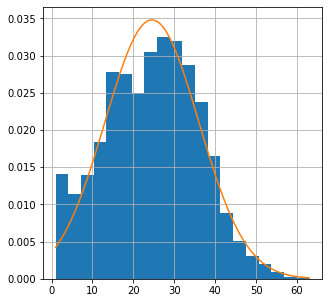

In [133]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_HeavyVehicle['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1,63, 100)
ax.plot(grid, st.exponnorm.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

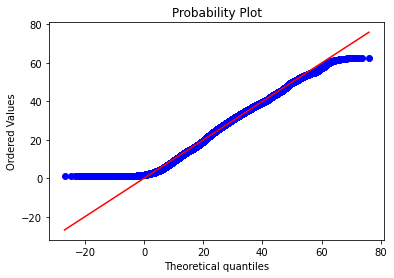

In [134]:
fig, ax = plt.subplots()
res = st.probplot(type_HeavyVehicle['speed'], sparams=(shape, loc, scale), dist=st.exponnorm, plot=ax)

In [135]:
expon_norm = st.exponnorm.sf(80,shape)
expon_norm

0.0

### - Power Law Distribution

In [136]:
shape, loc, scale = st.powerlaw.fit(type_HeavyVehicle['speed'])

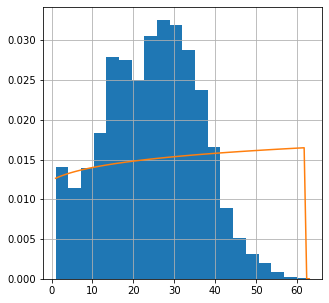

In [137]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(type_HeavyVehicle['speed'], density = True, range=(1,63), bins = 20)
grid = np.linspace(1,63, 100)
ax.plot(grid, st.powerlaw.pdf(grid, shape, loc = loc, scale = scale))
ax.grid()
plt.show()

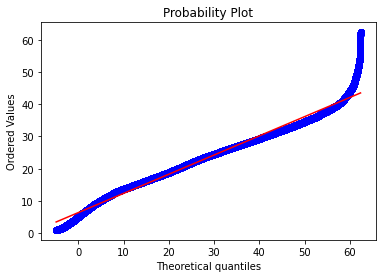

In [138]:
fig, ax = plt.subplots()
res = st.probplot(type_HeavyVehicle['speed'], sparams=(shape, loc, scale), dist=st.powerlaw, plot=ax)

In [139]:
powelaw = st.powerlaw.sf(80,shape)
powelaw

0.0

### -----------------------------------------------------------------------------------------------------------------

In [ ]:
a = delayed(len)(df)
a.compute()

In [ ]:
len(df)

In [ ]:
#x-axis is for longitude, y-axis is for latitude and the corresponding geometry is used
points = gpd.points_from_xy(test["lon"],test["lat"], crs="EPSG:4326")
points2 = gpd.points_from_xy(test["lon"],test["lat"], crs="EPSG:4326")

In [ ]:
# Dataframes used to test that we can plot the trajectory of the vehicle
gdf = gpd.GeoDataFrame(test, geometry=points)
gdf2 = gpd.GeoDataFrame(test, geometry=points2)

In [ ]:
#Getting the correct datatime of the file
basedata = get_basedate("20181024_d1_0830_0900.csv")

In [ ]:
# Function lambda to apply and correct the time
date = lambda x: basedata + timedelta(seconds=x)

In [ ]:
#Testing the dataframes and applying the correction
gdf["time"] = gdf.time.apply(date)
gdf2["time"] = gdf2.time.apply(date)

In [ ]:
gdf


In [ ]:
#Setting the time as index to plot it
gdf = gdf.set_index(gdf.time)
gdf2 = gdf2.set_index(gdf.time)

In [ ]:
# Dropping the columns that are not needed.
gdf.drop(columns="time", inplace=True)
gdf2.drop(columns="time", inplace=True)

In [ ]:
gdf

In [ ]:
#GEtting the trajectory
traj = mpd.Trajectory(gdf, 1)
traj2 = mpd.Trajectory(gdf2, 1)

In [ ]:
# Plotting how the trajetory looks
traj.plot()
plt.show()

In [ ]:
traj2.plot()
plt.show()

In [ ]:
# Plotting the path of the vehicle
traj.hvplot(geo=True, title='First Vehicle', line_width=5, frame_width=300, frame_height=300)


In [ ]:
# Plotting the path of the vehicle
traj2.hvplot(geo=True, title='Second Vehicle', line_width=5, frame_width=300, frame_height=300)

In [ ]:
# NOTE: it seems ids are not unique among files, we need to create our own unique ids.
# SOL: append id to ymd for unique ids TODO: need to verify per file IDs are indeed unique

def line_to_df(line, date_cols):
    """ Line is a string delimited by ; with trailing newline.
    Create a small df with each line and return it. """
    
    line = line.strip().split(';')[:-1]
    track_id, type_, traveled_d, avg_speed = line[:4]
    lon = np.array(line[5::6], dtype=float)
    lat = np.array(line[4::6], dtype=float)
    #speed = np.array(line[6::6], dtype=float)
    #lon_acc = np.array(line[7::6], dtype=float)
    #lat_acc = np.array(line[8::6], dtype=float)
    
    # Date information
    n = len(lon)
    ymd, hour, mins = date_cols
    ID = np.full(n, int(str(ymd) + track_id), dtype=int)
    
    # It seems time in secs from the start of the experiment chunk
    # Since precision given in sec with two decimals,
    # Rewrite in miliseconds since 8 (integer, avoid precision issues)
    secs = np.array((np.array(line[9::6], dtype=float) + (hour - 8)*3600)*1000, dtype=int)
    
    df = pd.DataFrame({'ID': ID, 'lon': lon, 'lat': lat, 'secs': secs})
    
    return df

In [ ]:

pat = re.compile(r'^([0-9]{8})_d1_([0-9]{2})([0-9]{2})_([0-9]{2})([0-9]{2})\.csv')
def get_date_cols(fname, pat):
    ymd, start_hour, start_min, end_hour, end_min = [int(x) for x in pat.findall(fname)[0]]
    return ymd, start_hour, start_min


fname ="20181024_d1_0830_0900.csv"
date_cols = get_date_cols(fname, pat)

#f = open(f'pNeuma/{fname}')
f = open(fname)
f.readline()
dfs = [delayed(line_to_df)(l, date_cols) for l in f]
df = dd.from_delayed(dfs)

# Write dask df to parquet
df.to_parquet(fname.split('.')[0] + '-points.parquet')
f.close()


In [ ]:
date_cols

In [ ]:
df = dd.read_parquet(fname.split('.')[0] + '-points.parquet')


In [ ]:
df= df.to_pandas()

## Extra Material:
1. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%207/UAS4T.pdf
2. https://ieee-itsc2020.org/wp-content/uploads/2020/07/UAS-Collected-Traffic-Data-Analysis-UAS4T-Competition.pdf
3. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%2013/Traffic_prediction_competition_for_ITSC_2020.pdf
4. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%2015/UAS4T%20Competition%20-GUC-MRS-Overall%20Report%20.pdf
5. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%2018/Report.pdf
6. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%2021/uas4t_tl_team_report-revised.pdf
7. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%204/Proposed_Approach.pdf
8. https://github.com/UAS4TCompetition/Results/blob/master/Codes/Team%205/3.short%20paper%20explaining%20the%20approach.pdf